In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


In [2]:
train_path = "test_images"
batch_size = 5
resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)
os.getcwd()

'/Users/niklashjort/Desktop/Notes/Speciale/projects/MIT_Model'

In [6]:
# import os
# path = '/Users/myName/Desktop/directory'

# count = 0
# for folder in os.listdir(train_path):
#     print(folder)
#     for file in os.listdir(train_path + "/" + folder):
#         print(file)
#         print(len(file))
#         if(len(file)> 25):
#             try:
#                 x = file[:-10] + ".png"
#                 os.rename(train_path + "/" + folder + "/" + file, train_path + "/" + folder + "/" + x)
#                 os.remove(train_path + "/" + folder + "/" + file)
#             except:
#                 pass
#         print(x)

In [3]:
# train_path = "../../../windows_01_only_sz/win_chb_01"
# test_path = "../../../psd_dual_channel_10_patient/windows/test"
# resnet152_input_shape = (224, 224)
# inceptionV3_input_shape = (299, 299)
# batch_size = 20

In [5]:
os.remove(train_path + "/.DS_Store")

In [6]:
for f in os.listdir(train_path):
    print(f)

Seizure
Interictal
Preictal


In [7]:
from tensorflow.keras.applications import VGG16, ResNet152

In [8]:
labels = [item for item in os.listdir(train_path)]
labels

['Seizure', 'Interictal', 'Preictal']

In [9]:
def inspect_class_distribution():
    dist_list = {}
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        #dict = {classname, number_of_png}
        dist_list[classname] =  number_of_png
    return dist_list

inspect_class_distribution()

{'Seizure': '256', 'Interictal': '4537', 'Preictal': '1447'}

In [10]:
max_n_images = int(inspect_class_distribution().get('Seizure'))

In [11]:
myList = random.sample(range(1, 100),100-1)

# taking an input list
l1 = []
  
# taking an counter
count = 0
  
# travesing the array
for item in myList:
    if item not in l1:
        count += 1
        l1.append(item)
  
# printing the output
print("No of unique items are:", count)

No of unique items are: 99


In [12]:
path_list = random.sample(os.listdir(train_path + "/Interictal"), 2)

In [13]:
def limit_data(data_dir,n=max_n_images):
    a=[]
    for i in os.listdir(data_dir):
        image_path = random.sample(os.listdir(data_dir+'/'+i), max_n_images)
        for k,j in enumerate(image_path):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class'])

In [14]:
balanced_data = limit_data(train_path)

In [15]:
balanced_data.head()

,filename,class
0,test_images/Seizure/chb02_16_29_FP2-F4_09-34-5...,Seizure
1,test_images/Seizure/chb02_16_15_T8-P8_09-34-26...,Seizure
2,test_images/Seizure/chb02_16_28_T8-P8_09-34-52...,Seizure
3,test_images/Seizure/chb02_16_21_F3-C3_09-34-38...,Seizure
4,test_images/Seizure/chb02_16+_18_T8-P8_11-40-3...,Seizure


In [16]:
from sklearn.utils import shuffle

balanced_data = shuffle(balanced_data)

In [17]:
print(balanced_data['class'].nunique())
balanced_data['filename'].nunique()

3


768

In [18]:
Resnet = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)

for layer in Resnet.layers:
    layer.trainable = False

Resnet.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-11-04 00:33:54.704685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-04 00:33:54.705211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [19]:
model = Sequential()

model.add(Resnet)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 109,753,219
Trainable params: 51,382,275
Non-trainable params: 58,370,944
__________________________________

In [21]:
from tensorflow.keras.applications.resnet import preprocess_input

In [22]:
generator = ImageDataGenerator(
  validation_split=0.2,
  rescale=1.255,
  zoom_range=0.1
)

In [23]:
train_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=resnet152_input_shape, 
    shuffle=True,
    subset="training")

Found 614 validated image filenames belonging to 3 classes.


/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [24]:
validation_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=batch_size, 
    target_size=resnet152_input_shape, 
    shuffle=True,
 #   class_mode="binary",
    subset="validation")

Found 153 validated image filenames belonging to 3 classes.


/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [25]:
validation_gen.classes

[1,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 0]

In [26]:
x = 120
train_gen.classes[x:x+10]

[0, 1, 2, 0, 2, 1, 2, 1, 0, 2]

In [27]:
class_weights = {0: 0.4469741480611046,
                1: 1.0266531713900136,
                2: 1.5509683995922527,
                3: 6.947488584474886}

In [55]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(299,299,3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(512, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout())
# model.add(layers.Conv2D(256, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(4, activation='softmax'))

In [29]:
# model.summary()

In [28]:
from tensorflow.keras.optimizers import Adam, SGD
opt = Adam(0.00001)

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=['accuracy']
)

In [23]:
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [39]:
# lr_finder = LRFinder(min_lr=1e-5, 
#                     max_lr=1e-2, 
#                     steps_per_epoch=np.ceil(5/batch_size), 
#                     epochs=3)

In [41]:
def inspect_class_distribution():
    dist_list = []
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        dict = {classname, number_of_png}
        dist_list.append(dict)
    return dist_list

inspect_class_distribution()

[{'256', 'Seizure'}, {'4537', 'Interictal'}, {'1447', 'Preictal'}]

In [29]:
history = model.fit(
    train_gen,
    epochs=10,
    steps_per_epoch = train_gen.samples//batch_size, 
    validation_data=validation_gen, 
    validation_steps = validation_gen.samples//batch_size,
    #callbacks=[lr_finder]
    #class_weight=class_weights
    
)

2021-11-04 00:34:44.492863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-04 00:34:44.495514: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-11-04 00:34:46.595847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 4.1734 - accuracy: 0.3990

2021-11-04 00:36:23.081725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - 122s 974ms/step - loss: 4.1734 - accuracy: 0.3990 - val_loss: 1.3590 - val_accuracy: 0.5333
Epoch 2/10
122/122 [==============================] - 116s 947ms/step - loss: 1.4171 - accuracy: 0.5008 - val_loss: 0.9964 - val_accuracy: 0.4800
Epoch 3/10
122/122 [==============================] - 116s 947ms/step - loss: 1.0379 - accuracy: 0.5271 - val_loss: 0.8602 - val_accuracy: 0.5133
Epoch 4/10
122/122 [==============================] - 115s 946ms/step - loss: 0.9521 - accuracy: 0.5353 - val_loss: 0.8553 - val_accuracy: 0.5800
Epoch 5/10
122/122 [==============================] - 116s 950ms/step - loss: 0.9192 - accuracy: 0.5484 - val_loss: 0.9199 - val_accuracy: 0.5200
Epoch 6/10
122/122 [==============================] - 116s 952ms/step - loss: 0.9001 - accuracy: 0.5829 - val_loss: 0.9105 - val_accuracy: 0.5133
Epoch 7/10
122/122 [==============================] - 115s 946ms/step - loss: 0.8507 - accuracy: 0.6010 - val_loss: 0.8715 - val_accura

In [27]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(train_path).rglob("*.png")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

E:\Database\All_channel_chb_01\train\Interictal\chb01_16_198_FZ-CZ_03-15-49.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_199_FZ-CZ_03-15-53.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_200_FZ-CZ_03-15-57.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_201_FZ-CZ_03-16-01.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_202_FZ-CZ_03-16-05.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_203_FZ-CZ_03-16-09.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_204_FZ-CZ_03-16-13.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_205_FZ-CZ_03-16-17.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_206_FZ-CZ_03-16-21.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_207_FZ-CZ_03-16-25.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_208_FZ-CZ_03-16-29.png
E:\Database\All_channel_chb_01\train\Interictal\chb01_16_209_FZ-CZ_03-16-33.png
E:\Database\All_channel_chb_01\train\Int

In [27]:
#lr_finder.plot_loss()

In [28]:
#model.save("resnet_50ep_cnn.h5")

/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [29]:
with open('history.txt', 'w') as f:
    f.write(str(history.history))

<Figure size 216x288 with 0 Axes>

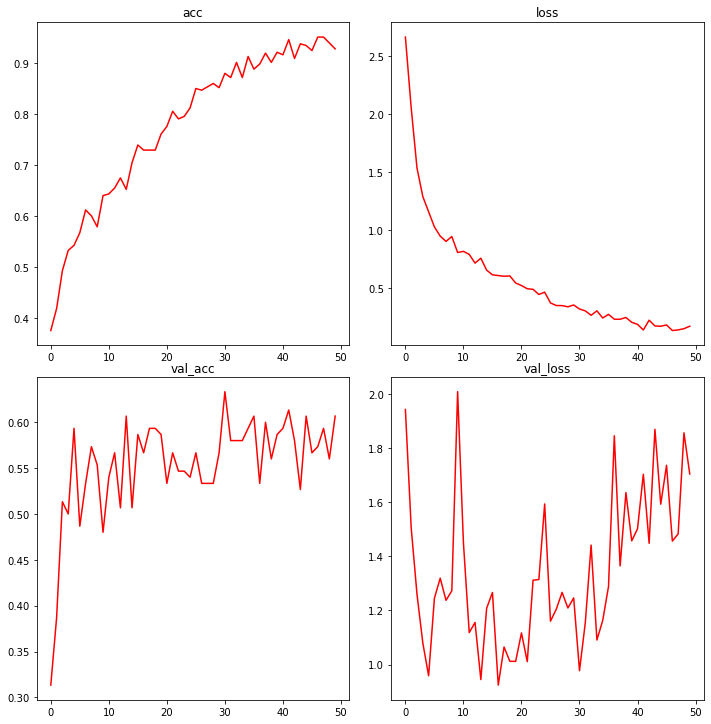

In [37]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
#plt.savefig("eval.png")

In [64]:
test_gen = generator.flow_from_dataframe(
    balanced_data,
    batch_size=1, 
    target_size=inceptionV3_input_shape, 
    shuffle=True,
 #   class_mode="binary",
    subset="validation")

Found 3343 validated image filenames belonging to 4 classes.


In [69]:
number_of_step = test_gen.samples // 1
number_of_step

3343

In [95]:
pred = model.predict(test_gen, steps=number_of_step)

In [96]:
y_pred_max = pred.argmax(axis=-1)

In [97]:
y_true = test_gen.classes

In [98]:
for i, x in enumerate(test_gen.classes[0:6]):
    filename = test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

index : 0, y_true : 1 : filename : E:\Database\All_channel_chb_01/train/Preictal_One/chb01_15_176_P8-O2_00-56-28.png
index : 1, y_true : 3 : filename : E:\Database\All_channel_chb_01/train/Seizure/chb01_18_32_F8-T8_04-14-50.png
index : 2, y_true : 2 : filename : E:\Database\All_channel_chb_01/train/Preictal_Two/chb01_18_10_FT9-FT10_04-04-26.png
index : 3, y_true : 1 : filename : E:\Database\All_channel_chb_01/train/Preictal_One/chb01_18_130_P3-O1_03-53-46.png
index : 4, y_true : 1 : filename : E:\Database\All_channel_chb_01/train/Preictal_One/chb01_18_53_P4-O2_03-48-38.png
index : 5, y_true : 3 : filename : E:\Database\All_channel_chb_01/train/Seizure/chb01_21_41_FP1-F3_06-40-35.png


In [99]:
labels = ['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure']

In [100]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

In [101]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [102]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.25      0.23      0.24       800
Preictal_One       0.27      0.30      0.28       846
Preictal_Two       0.24      0.22      0.23       832
     Seizure       0.26      0.26      0.26       865

    accuracy                           0.25      3343
   macro avg       0.25      0.25      0.25      3343
weighted avg       0.25      0.25      0.25      3343



In [105]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max), normalize='true')

confusion_matrix

TypeError: 'numpy.ndarray' object is not callable

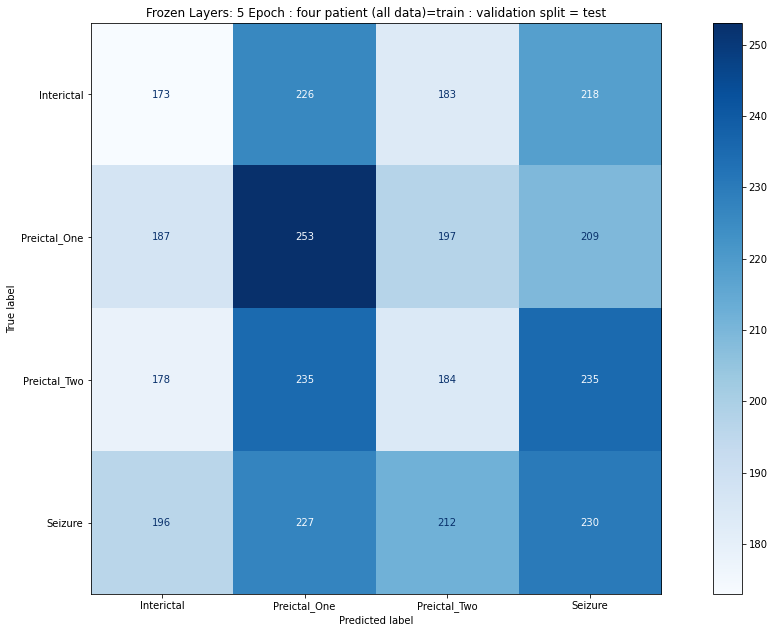

In [88]:
import matplotlib
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("resnet_only_sz_cb07_test.png")